In [ ]:
import numpy as np
import pandas as pd
import pickle
from zipfile import ZipFile
#import mne

# graphical libs
import matplotlib.pyplot as plt
%matplotlib widget
#import seaborn as sns

# ml libraries
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.metrics import classification_report, mean_squared_error
# from sklearn.model_selection import train_test_split
from sklearn.linear_model import  LinearRegression, LogisticRegression
from sklearn.preprocessing import MinMaxScaler 

import tensorflow as tf
from keras import backend as K
from tensorflow.keras.utils import plot_model

from scipy.signal import savgol_filter #, filtfilt, butter
from collections import deque

import xgboost as xgb

# set number of rows ti display
pd.set_option("display.max_rows", 9, "display.max_columns", 9)

# lib for interpretator processing
import sys, os
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# Hide output
from IPython.display import clear_output
#np.set_printoptions(suppress=True)

# Model serialization

import joblib

import serial
import time
#import json

In [ ]:
# Set requirements
#!pip install -qr ../requirements.txt

In [ ]:
# Библиотека вызова функций, специально разработанных для данного ноутбука
sys.path.insert(1, '../')

from utils.config_reader import config_reader
from utils.functions import add_diff  
 

# import constants from the config
config = config_reader('../config/data_config.json') 

# path for data
PATH = config.PATH

In [ ]:
import random

# Fix seed
seed_value = config.seed_value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 1. initiate random seed in Python
random.seed(seed_value)

# 2. initiate random seed in Numpy
np.random.seed(seed_value)

# 3. initiate random seed in Optuna
#sampler = TPESampler(seed=seed_value) # fix random seed

# 4. initiate random seed in tensorflow 
tf.random.set_seed(seed_value)
 
# 5. Конфигурация Tenzorflow
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [ ]:
# Reading files with ".npy" and 'csv' extension and saving them to the dictionnary "mounts"
mounts = dict()

with ZipFile(os.path.join(PATH, 'data.zip')) as myzip:
    for file in myzip.namelist():
            mounts[f"{file[:-4]}".format(file)] = pd.read_csv(myzip.open(file), index_col=0)

mounts.keys()

dict_keys(['free_movements_2', 'gestures_test_2', 'gestures_train_2', 'gestures_protocol_2', 'gestures_protocol', 'gestures_test', 'gestures_train', 'free_movements'])

### Gestures train and test

```Python
# Обозначения
[X features] '0', ..., '49' - каналы OMG датчиков
             'ACC0', 'ACC1', 'ACC2' - акселерометр (потенциально могут использоваться как факторы для модели)
              'GYR0', 'GYR1', 'GYR2' - гироскоп     (потенциально могут использоваться как факторы для модели)
[y target]   'ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5' - координаты пальцев в перчатке GLOVE
'BUTTON' - не используется
'SYNC' - синхронизация данных с протоколом
'ts' - метка времен
```

In [ ]:
# Обозначение колонок для удобства доступа
# [X features] '0', ..., '49' - каналы OMG датчиков
OMG_CH = [str(i) for i in range(50)]

# 'ACC0', 'ACC1', 'ACC2' - акселерометр (потенциально могут использоваться как факторы для модели)
ACC_CH = config.ACC_CH

# 'GYR0', 'GYR1', 'GYR2' - гироскоп     (потенциально могут использоваться как факторы для модели)
GYR_CH = config.GYR_CH

# [y target] = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5'] - координаты пальцев в перчатке GLOVE
GLOVE_CH = config.GLOVE_CH[:-1] # Датчик 'ENC5' не используем

# 'BUTTON' - не используется
BUTTON_SYNC_TS_CH = config.BUTTON_SYNC_TS_CH

# Обозначение признаков разницы
col_diff_names = [x + '_DIFF' for x in OMG_CH]
COLS = OMG_CH + col_diff_names

print(f"OMG_CH: {OMG_CH}")
print(f"ACC_CH: {ACC_CH}")
print(f"GYR_CH: {GYR_CH}")
print(f"GLOVE_CH: {GLOVE_CH}")
print(f"BUTTON_SYNC_TS_CH: {BUTTON_SYNC_TS_CH}")

print(
    mounts['gestures_train'].shape, 
    mounts['gestures_test'].shape, 
    mounts['gestures_train_2'].shape, 
    mounts['gestures_test_2'].shape)

OMG_CH: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']
ACC_CH: ['ACC0', 'ACC1', 'ACC2']
GYR_CH: ['GYR0', 'GYR1', 'GYR2']
GLOVE_CH: ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4']
BUTTON_SYNC_TS_CH: ['BUTTON', 'SYNC', 'ts']
(28976, 65) (7244, 65) (21320, 65) (5330, 65)


## Composition of X_train

In [ ]:
X_train_1, X_test_1 = mounts['gestures_train'][OMG_CH].values, mounts['gestures_test'][OMG_CH].values  
y_train_1, y_test_1 = mounts['gestures_train'][GLOVE_CH].values, mounts['gestures_test'][GLOVE_CH].values

X_train_2, X_test_2 = mounts['gestures_train_2'][OMG_CH].values, mounts['gestures_test_2'][OMG_CH].values 

y_train_2, y_test_2 = mounts['gestures_train_2'][GLOVE_CH].values, mounts['gestures_test_2'][GLOVE_CH].values

# Preprocessing

In [ ]:
# Combine 2 pilots data
X_train_raw, X_test_raw = np.concatenate((X_train_1, X_train_2), axis=0), np.concatenate((X_test_1, X_test_2), axis=0)
y_train, y_test = np.concatenate((y_train_1, y_train_2), axis=0), np.concatenate((y_test_1, y_test_2), axis=0)

In [ ]:
# # Scaling values
scaler = MinMaxScaler()
#scaler = joblib.load(os.path.join(config.PATH_MODEL, config.scaler_name))
X_train, X_test, = scaler.fit_transform(X_train_raw), scaler.transform(X_test_raw) 

In [ ]:
def add_diff(arr:np.array, shift_=1)-> np.array:
    """Concatenation of a array values with shifted by a given step values.

    Args:
        arr (np.array): exhisting array
        shift_ (int, optional): shift of a rolling window. Defaults to 1.

    Returns:
        (np.array): concatenated array
    """    
    diff_arr = np.vstack([np.zeros((shift_, arr.shape[1])), (arr-np.roll(arr, shift_, axis=0))[shift_:]])
    return np.hstack([arr, diff_arr])

In [ ]:
# Add differential values
X_train, X_test  = add_diff(X_train, shift_=5), add_diff(X_test, shift_=5)  

In [ ]:
# # Smoothing of sensor signals
# X_train = np.transpose([savgol_filter(X_train[:,i], window_length=5, polyorder=2) for i in range(X_train.shape[1])]) 
# X_test = np.transpose([savgol_filter(X_test[:,i], window_length=5, polyorder=2) for i in range(X_test.shape[1])])

# Model

In [ ]:
import xgboost as xgb

# параметры оптимизированы optun'ой
params = {
    'learning_rate': 0.06329973864656831,
    'max_depth': 6,
    'subsample': 0.9814063371832862,
    'colsample_bytree': 0.41087811860602663,
    'min_child_weight': 8
}

# Creation an instance
model_xgb = xgb.XGBRegressor(**params)

# Train the Model
model_xgb.fit(X_train, y_train)
 
# # Predict target values
# y_pred = model_xgb.predict(X_test)#.round() 
 
# # Display metrics
# get_mse(y_test, y_pred)

# # Display comparison plot
# get_signals_comparison_plot(y_train, y_test, y_pred=y_pred, only_test=1)

# Real-time inference

In [ ]:
# crc_table = [
#     54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
#     111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
#     113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
#     179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
#     115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
#     88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
#     97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
#     45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
#     153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
#     114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
#     215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
#     0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
#     18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
#     57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
#     193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
#     213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
#     137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
#     67, 112, 109, 78, 114, 165, 244, 183, 121
# ];
    
# def get_crc(data, count):
#     result = 0x00
#     l = count
#     while (count>0):   
#         result = crc_table[result ^ data[l-count]]
#         count -= 1;
#     return result;

# def drv_abs_one(ser, control):
#     if ser is None:
#         return
#     pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
#     pack[-1] = get_crc(pack[1:], 9)
#     return (pack, ser.write(bytearray(pack)))

## Inference Utils

In [ ]:
df_sim = mounts['gestures_train'].copy()#.iloc[:10000]
df_sim = df_sim.values[:461,:50].astype(np.int16)
df_sim.shape

(461, 50)

In [ ]:
# Scaling
#scaler = joblib.load(os.path.join(config.PATH_MODEL, config.scaler_name))
scaler=scaler

# Empty buffer for data
buff = np.zeros((5,50))
 

def preprocessing(x:np.array, buff:np.array=buff,  scaler=scaler):
    
    buff[0], buff[1], buff[2], buff[3] = buff[1], buff[2], buff[3], buff[4]
    
    #x - sample vector
    x_scaled = scaler.transform(x.reshape(1,-1))[0]
    
    buff[4] =  x_scaled 
    
    y = np.hstack([x_scaled, buff[4]- buff[3]])
    
    buff = np.transpose([savgol_filter(buff[:,i], window_length=5, polyorder=2, axis=0) for i in range(buff.shape[1])])[:,:5]
    
    return y, buff 

In [ ]:
for i in range(df_sim.shape[0]):
    y, buff = preprocessing(df_sim[i])

In [ ]:
x = y.copy()

# # loading linear regression model
# with open(os.path.join(config.PATH_MODEL+'xgb.pkl'), 'rb') as f:
#     model_xgb = pickle.load(f)


def inference(x:np.array, saved_model=model_xgb)->np.array: 
    """Get inference using saved model

    Args:
        x (np.array): input vector
        saved_model (...): ml model

    Returns:
        (np.array): preiction
    """
    x = x.reshape(1,-1)
    
    # Lin regression model
    if type(saved_model)==xgb.sklearn.XGBRegressor:
       y_pred = saved_model.predict(x)[0].round() #y.reshape(1,-1) 
     
    return y_pred

predict = inference(x, saved_model=model_xgb)
predict

array([11., 19., 30., 32., 44.])

In [ ]:
# set empty buffer
buff_pred = np.zeros((2,5))

In [ ]:
def postprocessing(x:np.array=predict, buff_pred:np.array=buff_pred, preproc_coef:float=0.57)->np.array:
    """postprocessing of prediction

    Args:
        x (np.array): _description_. Defaults to predict.
        buff_pred (np.array): prediction buffer
        preproc_coef (float, optional): _description_. Defaults to 0.57.

    Returns:
        np.array: _description_
    """    
    buff_pred[1], buff_pred[0] = buff_pred[0], np.clip(predict, 0, 100)
    
    if np.mean(buff_pred[1])==0:
        y = x
       
    else:
        y = predict*preproc_coef + buff_pred[1]*(1-preproc_coef) # Holt-Winters filter 0.1i 0.9i-1
    
    y = np.clip(y, 0, 100)

    return y, buff_pred

res,  buff_pred = postprocessing(predict, buff_pred)
buff_pred 

array([[11., 19., 30., 32., 44.],
       [ 0.,  0.,  0.,  0.,  0.]])

In [ ]:
def commands(x):
    y = np.round(np.clip(x / 100, 0, 1)*100).astype(int)
    return y

clipped = commands(res)
clipped

array([11, 19, 30, 32, 44])

## Эмуляция

In [ ]:
df_sim = mounts['gestures_test'].iloc[:100]

#df_sim = free_movements.iloc[:2000]
print(df_sim.shape)

(1000, 65)


In [ ]:
TIMEOUT = 0.033 #0.033
DEBUG = True

ts_list = [] 
    
i = 0

buff = np.zeros((6,50))
buff_pred = np.zeros((2,5))

ts_diff = 0 
 
y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    #'y_commands':[],
    #'y_list':[],
}

# # loading xgb model
# with open(os.path.join(config.PATH_MODEL+'xgb.pkl'), 'rb') as f:
#     model_xgb = pickle.load(f)

ts_old = time.time()

while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
    
    except Exception as e:
        print(e)
    
    # [Data preprocessing]
    sample_preprocessed, buff = preprocessing(omg_sample)
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed, model_xgb)#model_stateful
    
    # [Inference Postprocessing]
    y_postprocessed, buff_pred     = postprocessing(y_predicted)
    
    # [Commands composition]
    #y_commands          = commands(y_postprocessed)

    
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    #y_dct['y_commands'].append(y_commands)
    

    
    if DEBUG:
        clear_output(wait=True)

        #sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        #print(y_commands)
        
    
    ts_diff = time.time() - ts_start
    ts_list.append(ts_diff) # проверю времена выполнения
    
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    
    ts_old = ts_start
    i += 1 

SAMPLE SIZE: 65, OMG: 50, ACC: 6, ENCODERS: 6
BUTTON: 0, SYNC: 244, TS: 2164131


In [ ]:
print('Время вычисления', np.mean(ts_list).round(3) , 'с')

Время вычисления 0.014 с


## Inference

### Offline (dataset)

In [ ]:
df_sim = mounts['gestures_test'].iloc[2000:2500]
#df_sim = free_movements.iloc[:2000]
print(df_sim.shape)

TIMEOUT = 0.033
DEBUG = True
    
i = 0
ts_diff = 0

buff = np.zeros((6,50))
buff_pred = np.zeros((2,5))
ts_old = time.time()

y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
}

# # loading xgb model
# with open(os.path.join(config.PATH_MODEL+'xgb.pkl'), 'rb') as f:
#     model_xgb = pickle.load(f)


while True:    
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
        
    # [Data preprocessing]
    sample_preprocessed, buff = preprocessing(omg_sample)
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed, model_xgb)
  
    # [Inference Postprocessing]
    y_postprocessed, buff_pred     = postprocessing(y_predicted)
  
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    # [/Data logging]

    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        #print(y_commands)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 

SAMPLE SIZE: 65, OMG: 50, ACC: 6, ENCODERS: 6
BUTTON: 0, SYNC: 256, TS: 2213631


In [ ]:
for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (500, 50)
enc_sample.shape = (500, 6)
sample_preprocessed.shape = (500, 100)
y_predicted.shape = (500, 5)
y_postprocessed.shape = (500, 5)
y_commands.shape = (500, 5)


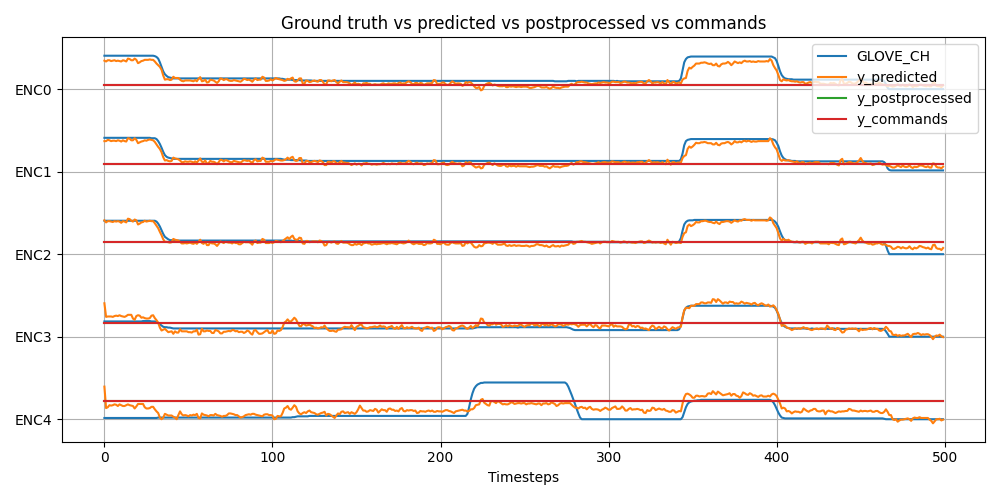

In [ ]:
xticks = df_sim[GLOVE_CH].index
dist = -np.arange(len(GLOVE_CH)) * 200

fig, ax = plt.subplots(1, 1,  figsize=(10, 4))

ax.plot(xticks, df_sim[GLOVE_CH] + dist, c='C0', label='GLOVE_CH')#, label='GLOVE_CH'
ax.plot(xticks, y_dct['y_predicted'] + dist, c='C1', label='y_predicted')#
ax.plot(xticks,  y_dct['y_postprocessed'] + dist, c='C2', label='y_post') #
ax.plot(xticks,   y_dct['y_commands'] + dist, c='C3', label ='commands') #

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(dist, GLOVE_CH)

# get unique labels
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
ax.legend(handles, labels, bbox_to_anchor=[1.04, 1]) 

plt.grid()
plt.tight_layout()

### Online (prosthesis or virtual hand)

In [ ]:
TIMEOUT = 0.033
DEBUG = True

ser = None
# ser_port = None
ser_port = '/dev/cu.usbmodem3498365F31351'

if ser_port is not None:
    ser = serial.Serial(port=ser_port, timeout=2*TIMEOUT)
    ser.write('T1#\r\n'.encode('utf-8')) # T1 for Timestamp activate
    ser.write('M2#\r\n'.encode('utf-8')) # M2 for Mode == 2 = send samples
    ser.write('S2#\r\n'.encode('utf-8')) # SYNC to 2 for sanity check

    # flush buffers
    ser.reset_input_buffer()
    ser.read()
    
    i = 0;
    while(ser.in_waiting):
        print(f'Flushing buffers {i}: {ser.in_waiting}', end='    \r')
        ser.read_all()
        time.sleep(0.005)
        i+=1;
    ser.readline()
    ser.readline()
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
while True:    
    
    # [Data reading]
    s = ser.readline()
    ts_start = time.time()
    
    try:
        sample = np.array(s.decode('UTF-8')\
                           .replace('\r\n', "")\
                           .split(' ')
                         ).astype(int)
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    pack, _ = drv_abs_one(ser, list(y_commands)); # + [0]
    # [/Commands sending]
    
    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: iteration should increase monotonically, TIMEDIFF approximately 32-34 ms, CYCLETIME < TIMEOUT, WAITING should be == 0
        print(f'ITERATION:\t{i}\tTIMEDIFF:\t{(ts_start - ts_old)*1000: .0f}\tCYCLETIME:\t{ts_diff*1000:.0f}\tWAITING:\t{ser.in_waiting}')
        print('INPUT:\n', s)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
        print(pack)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 